# OTE

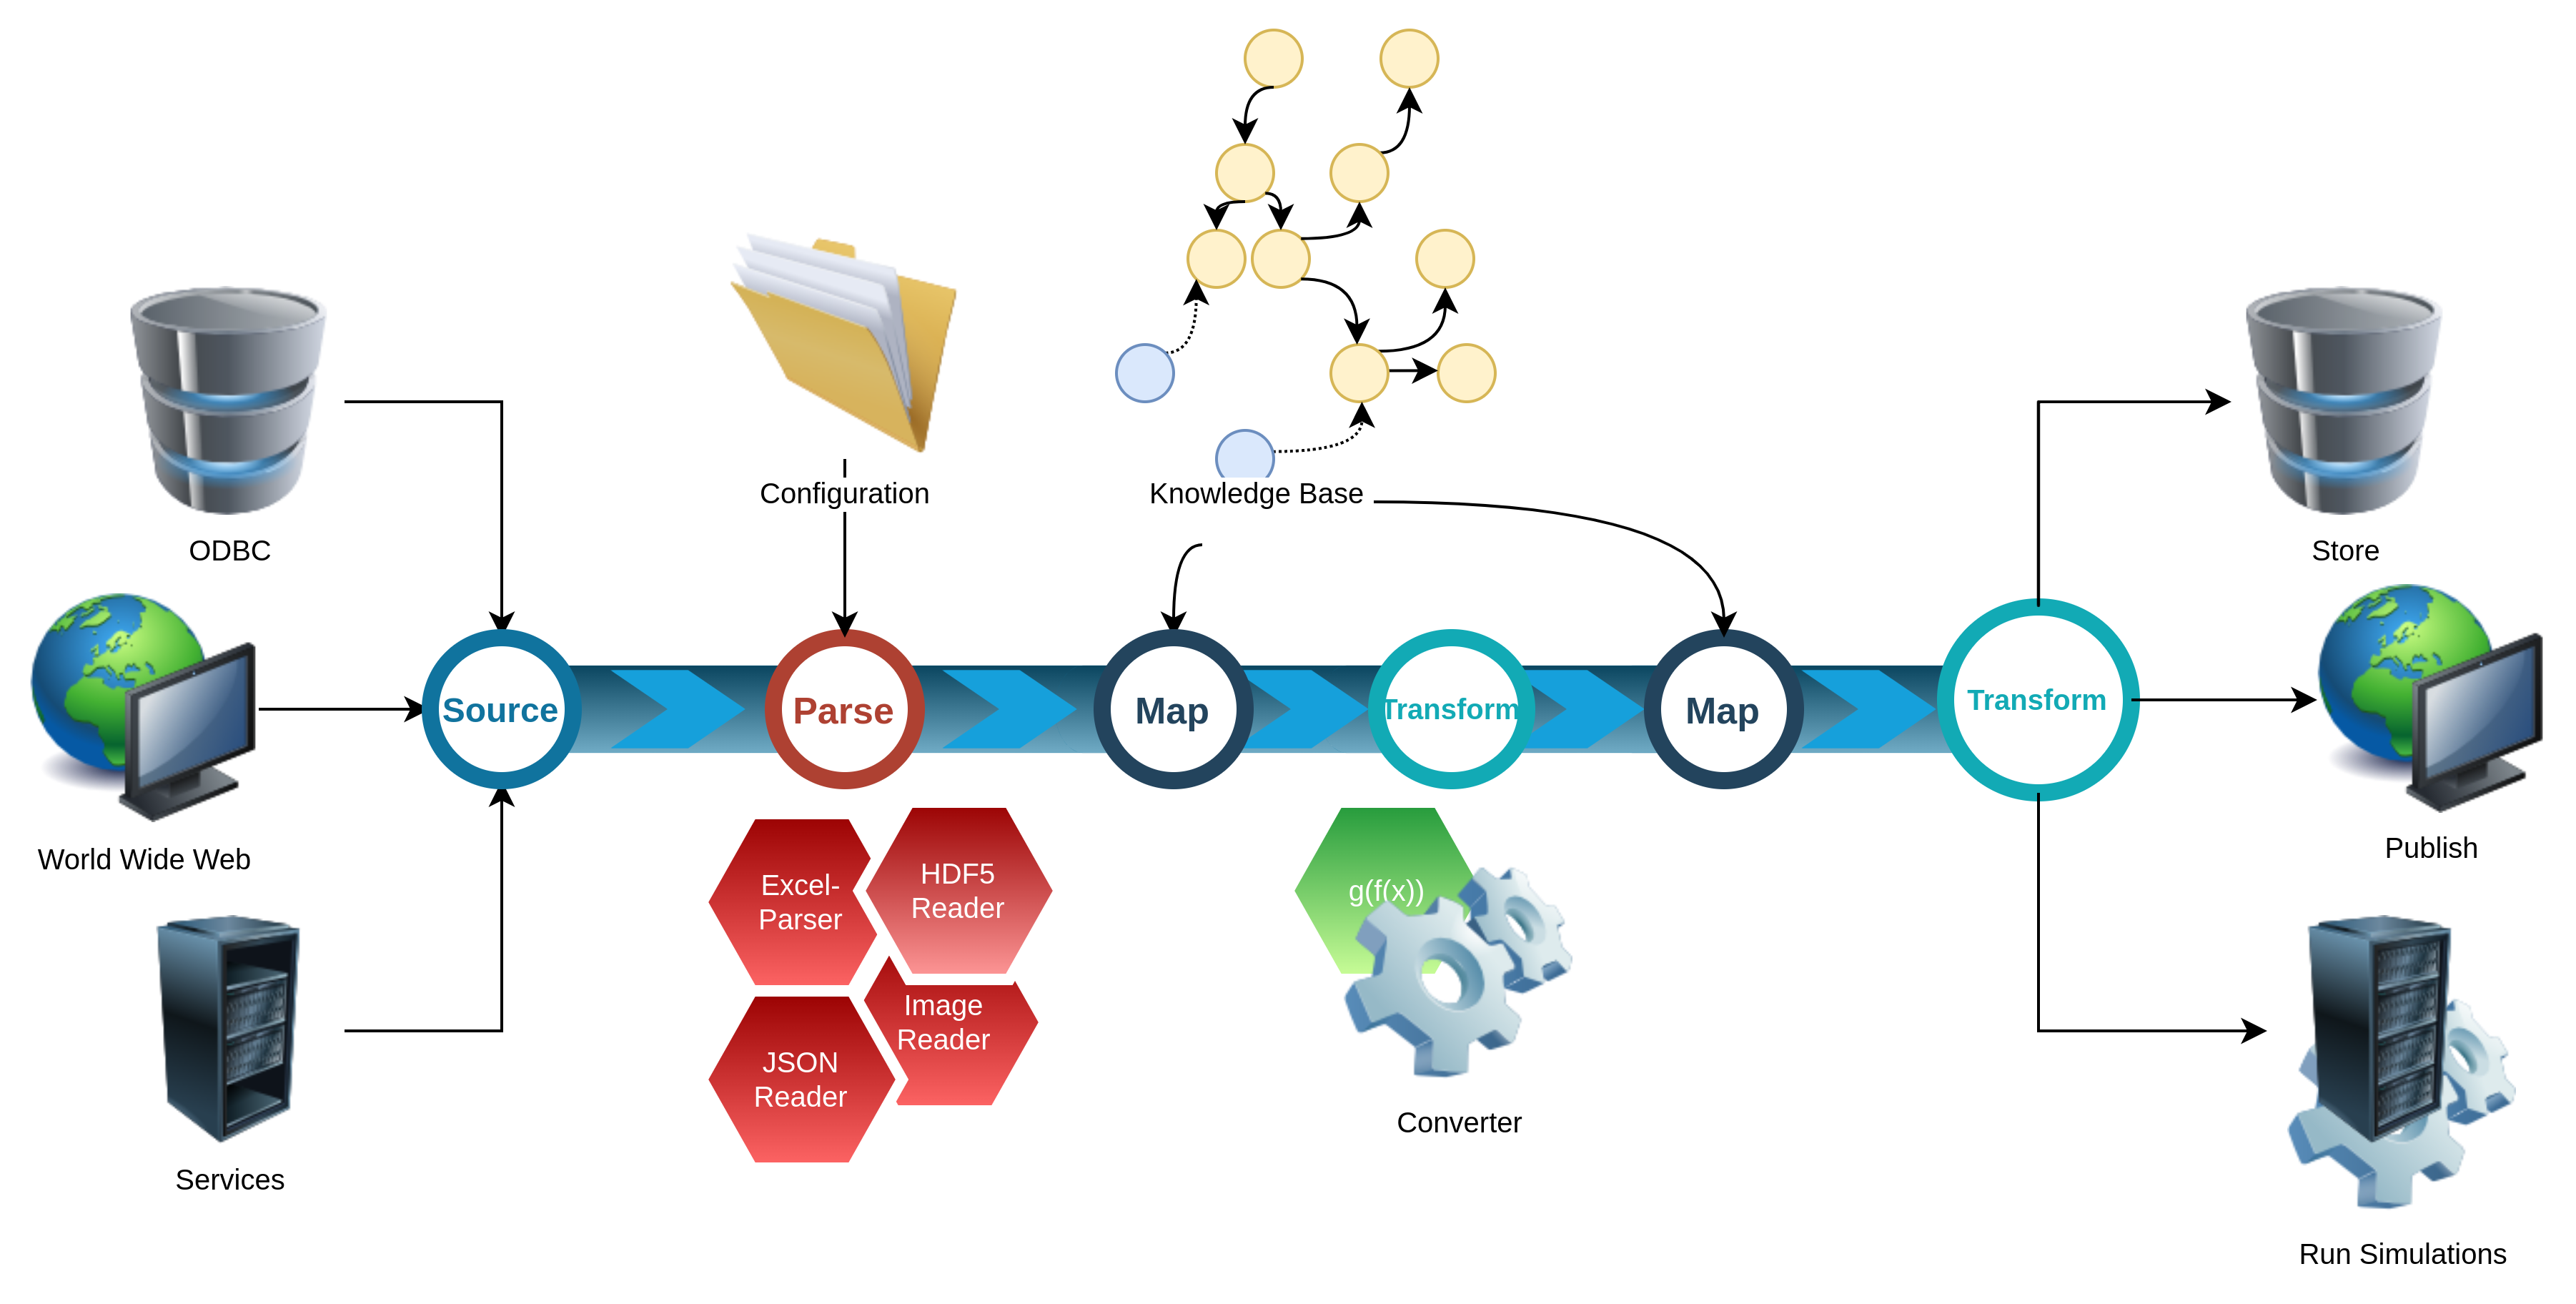


## Overview

A pipeline connects data from various sources to a target destination (simulation, analysis, publishing, ++)

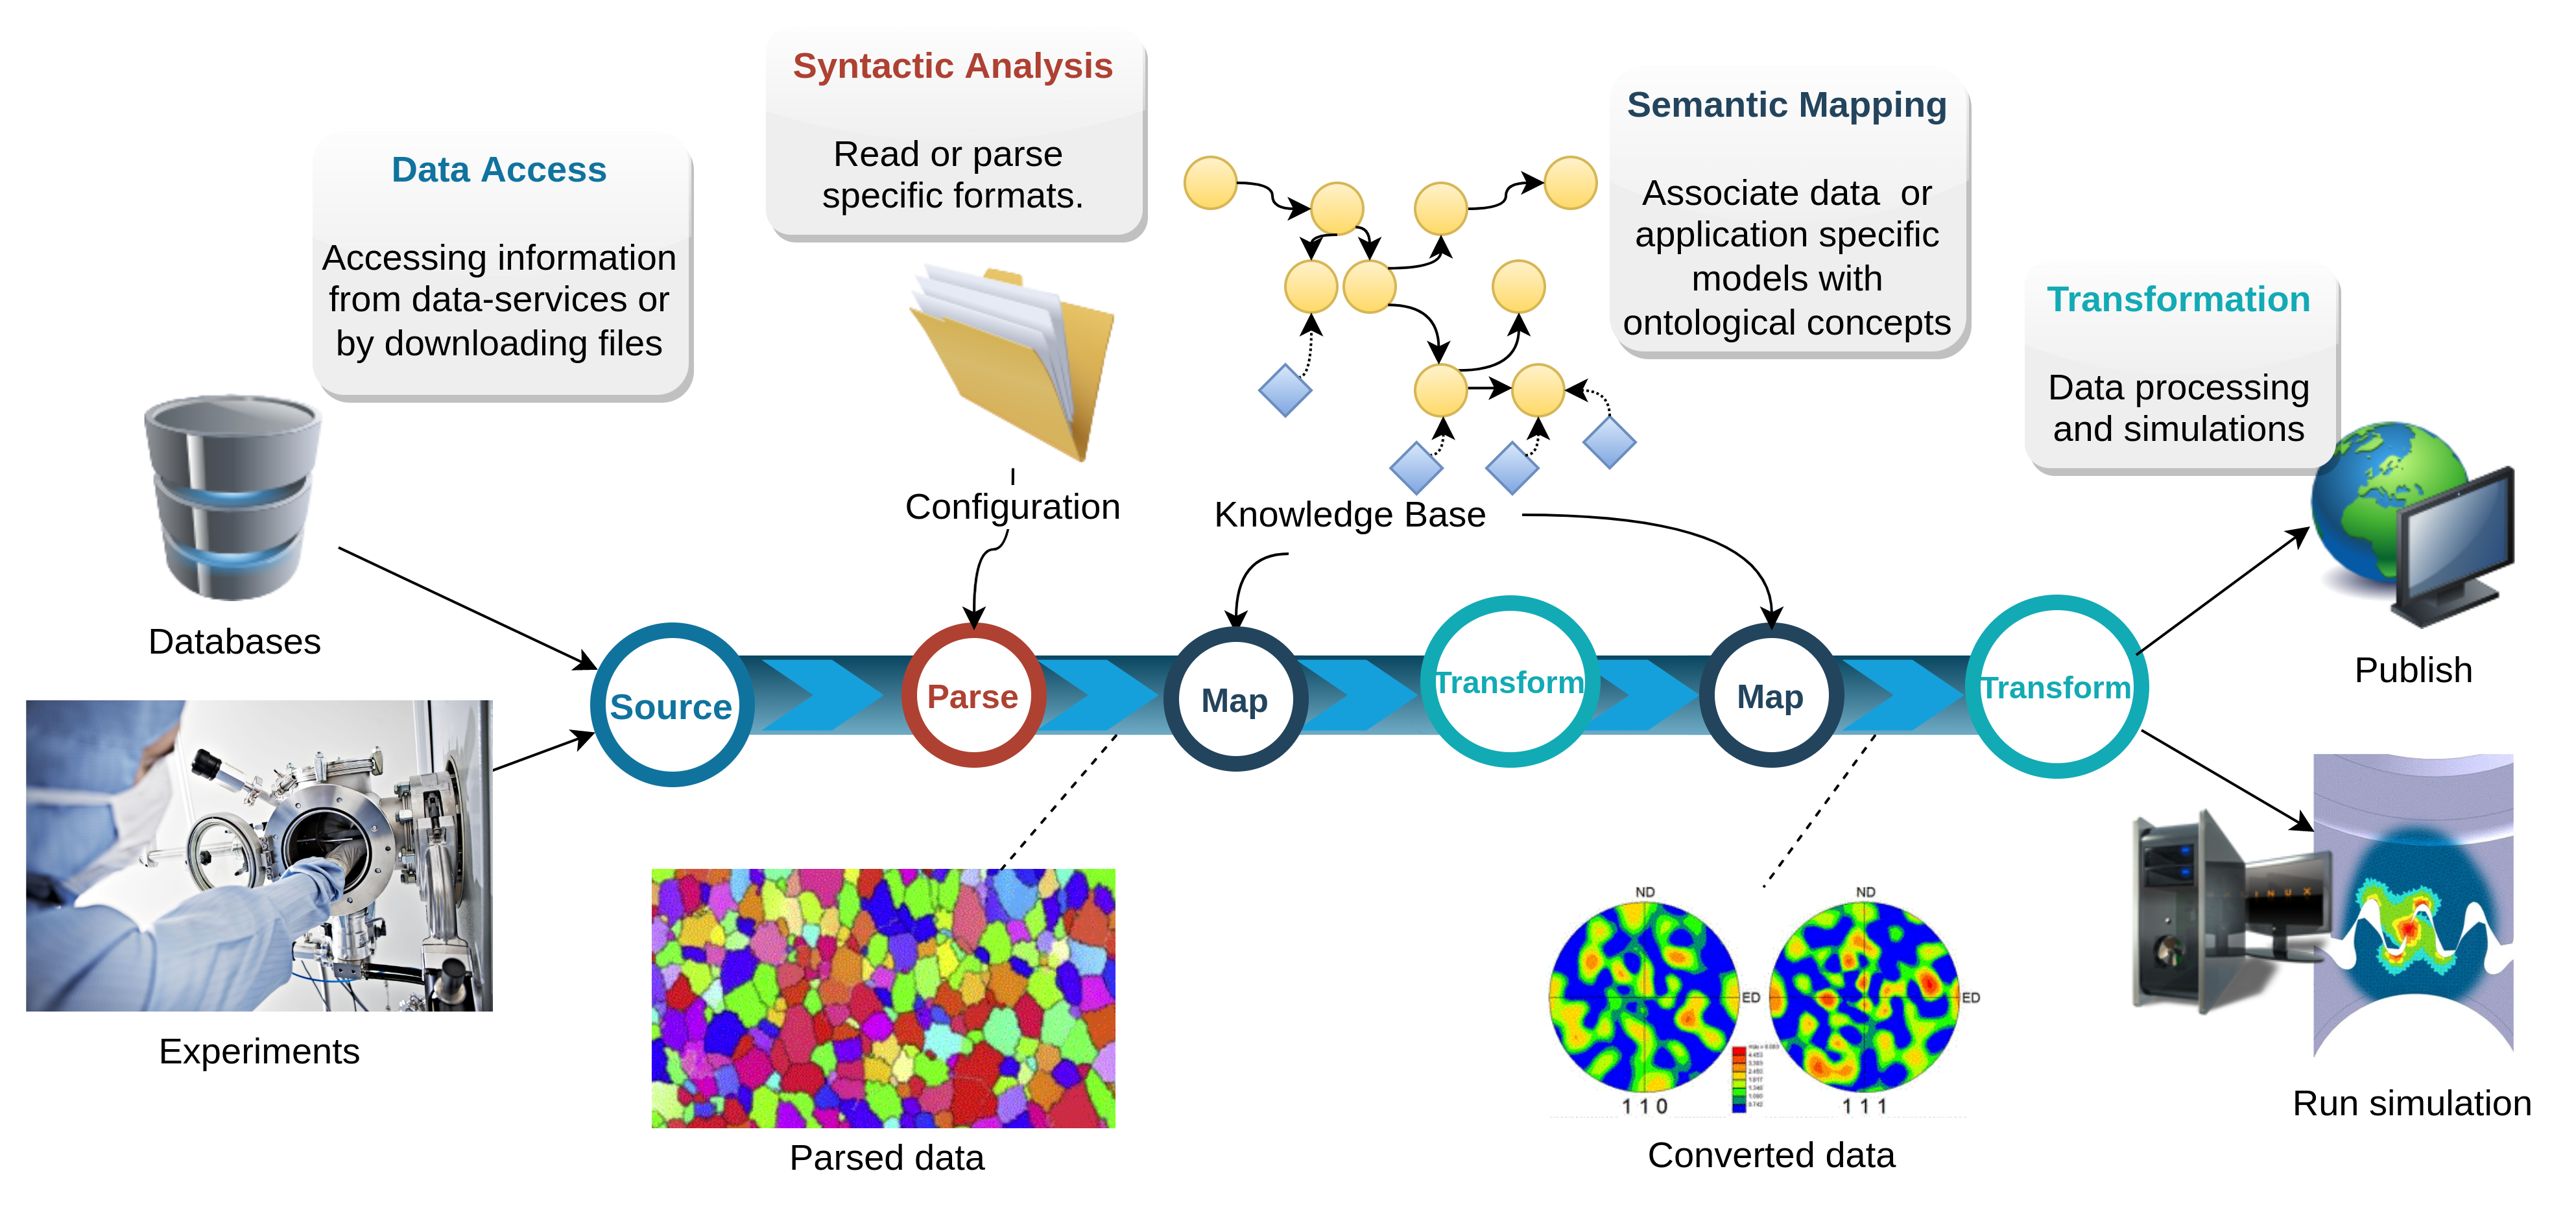


## Pipe & Filter

Construct data-flow using Pipe & Filter
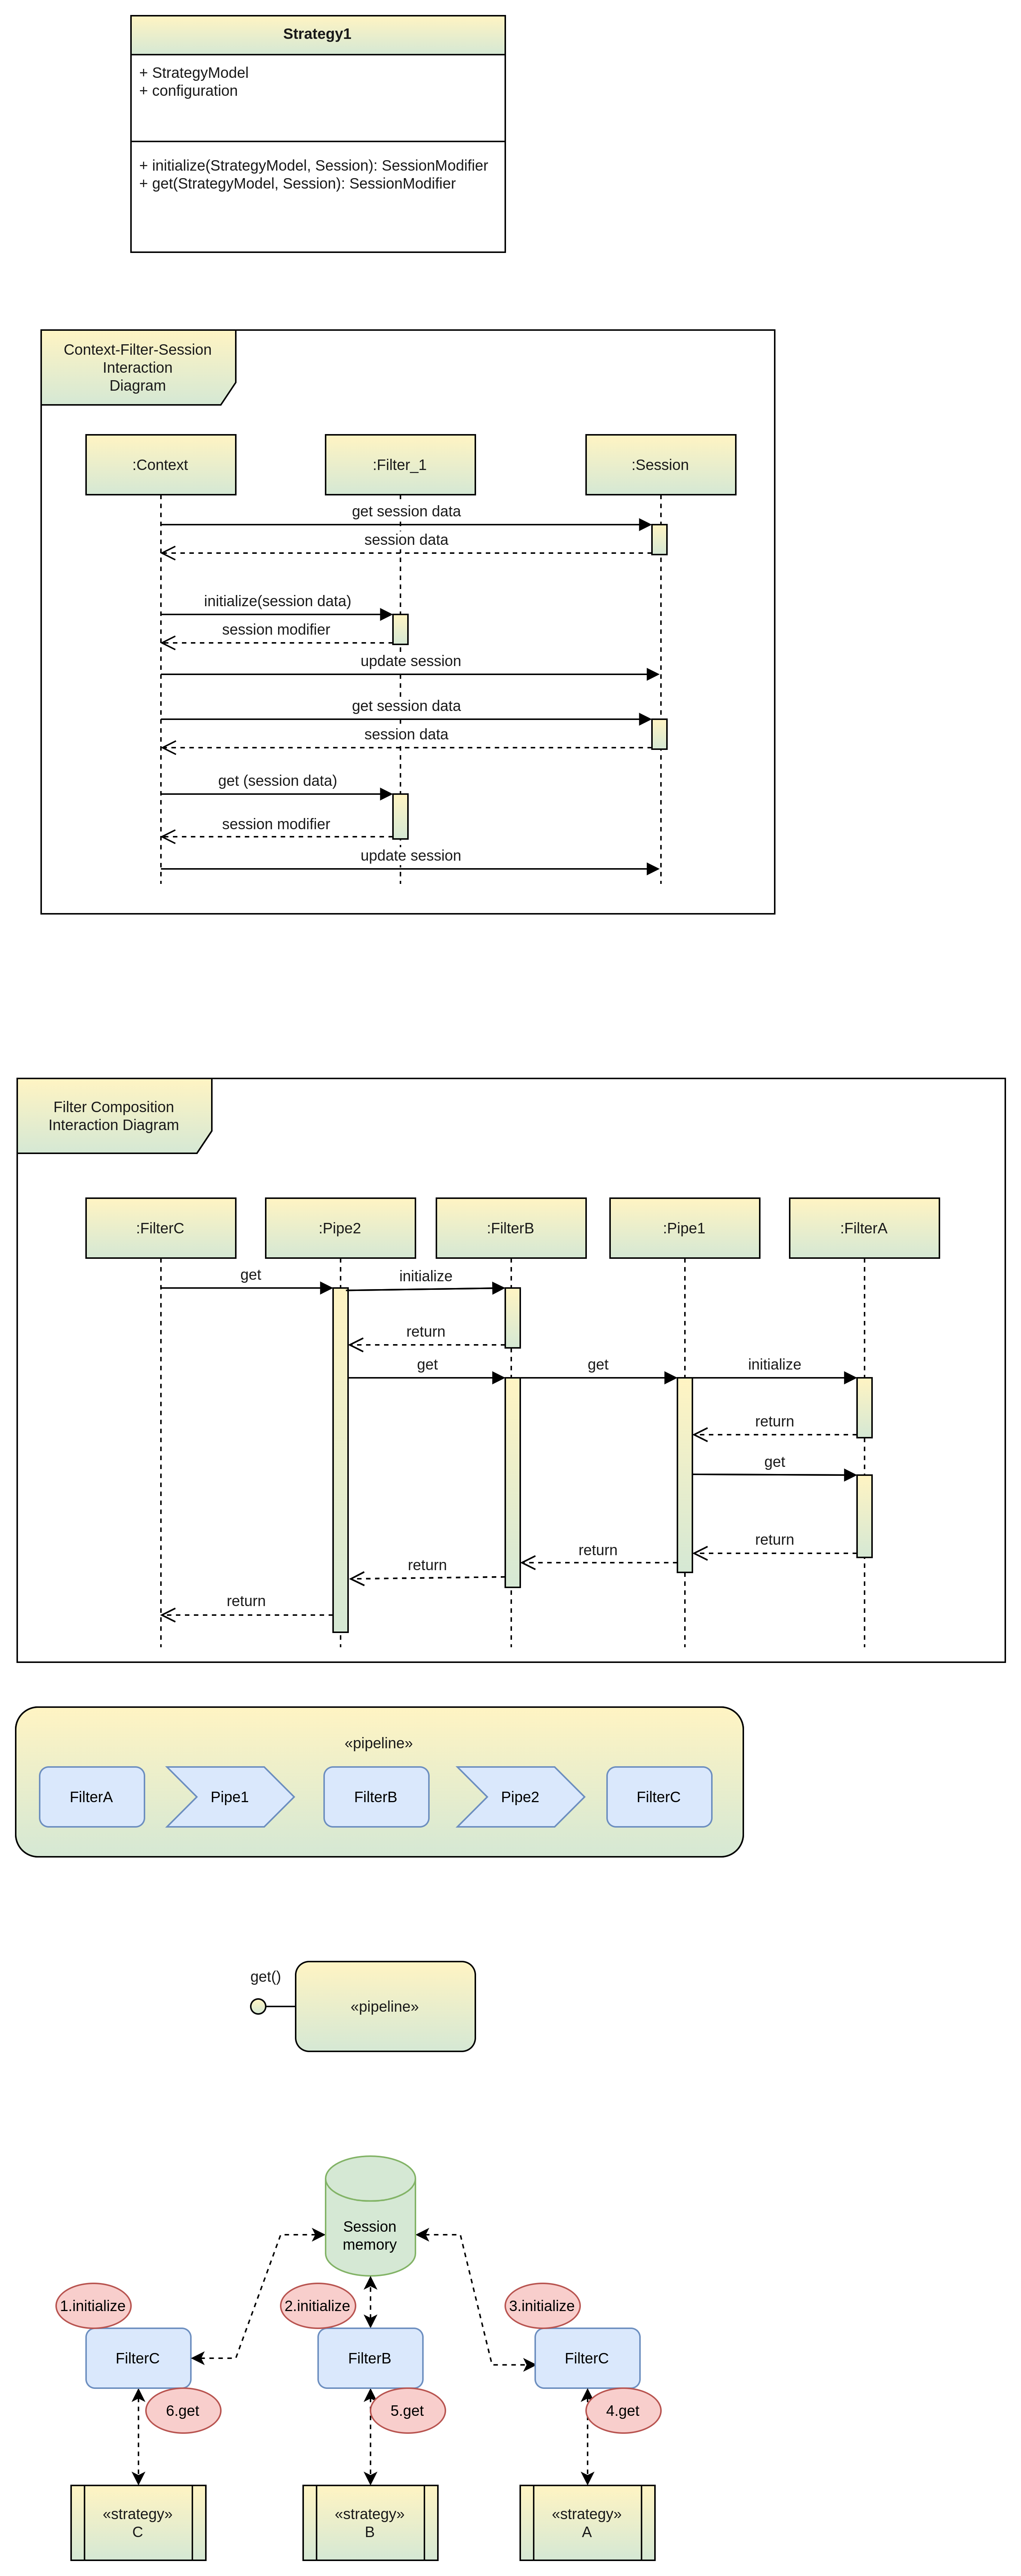


## Mappings and mapping functions
Describe ontological relations with mappings and function ontology

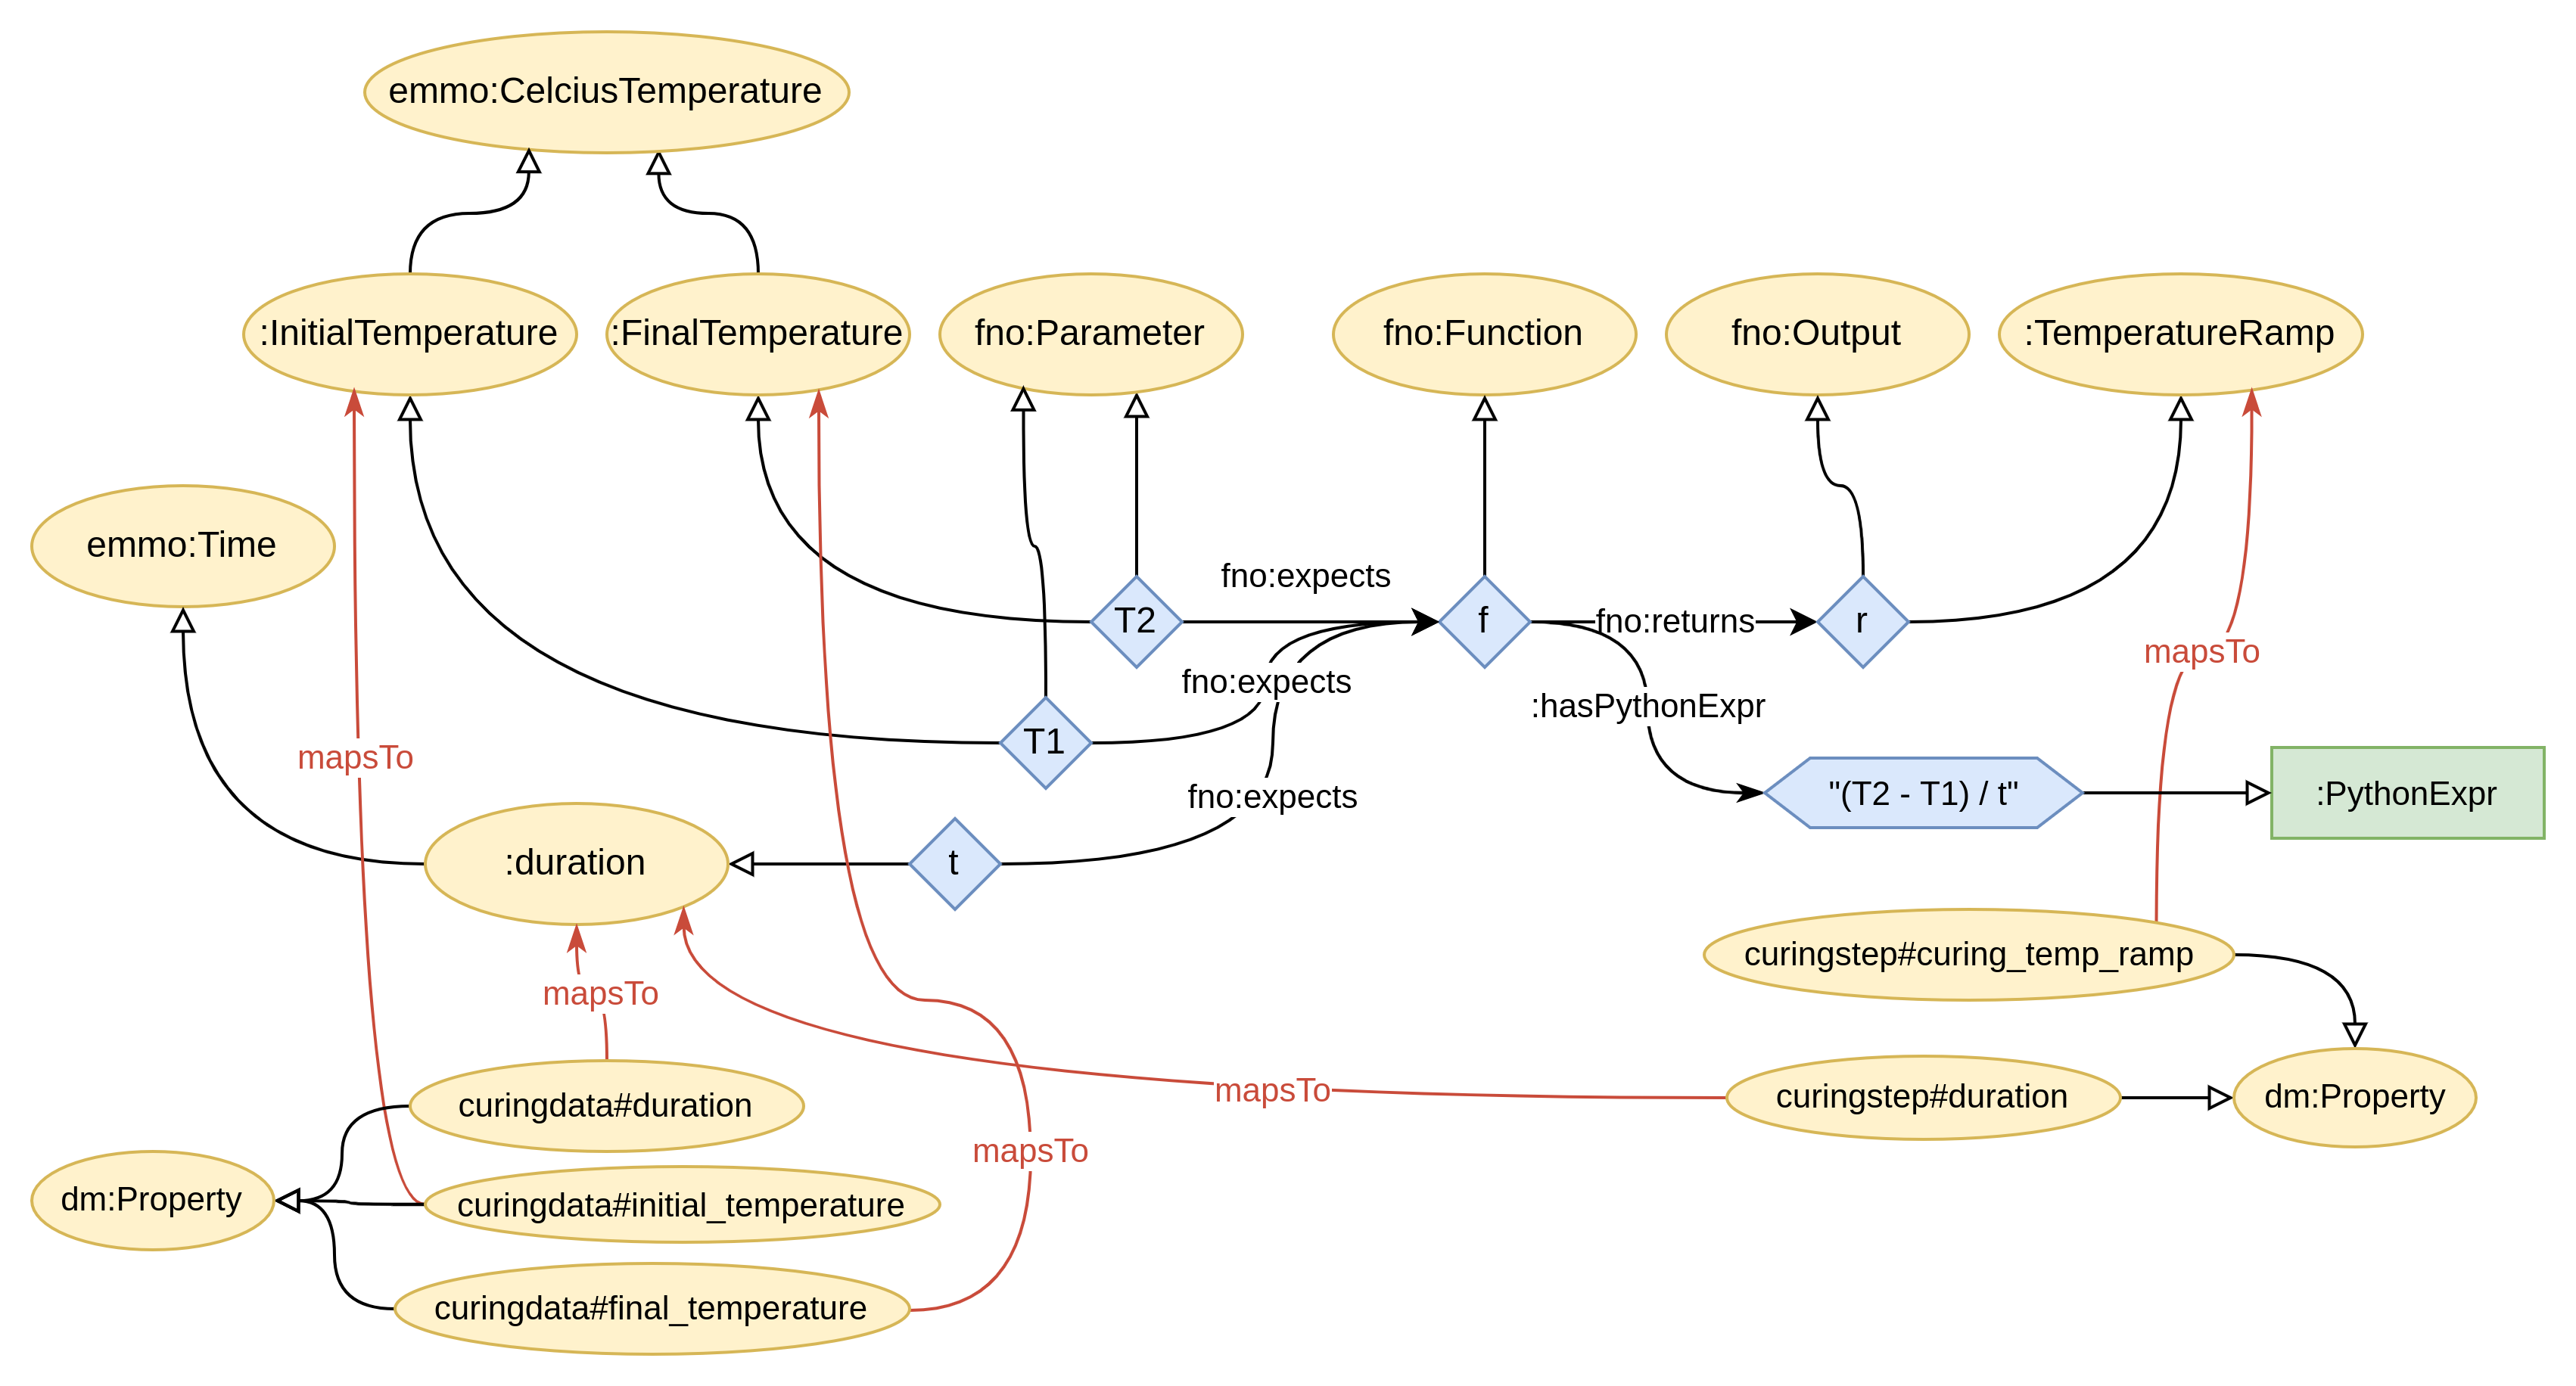



In [1]:
from s7.graph import Graph
import functools


# Ontological-Concept-Function given
# using cache in case the function is called multiple times with same parameters
@functools.cache
def add(a : float,b : float):
    print ('adding the numbers!')
    return a+b


# Our simple datasource and getters
datasource = [1,2,3,4,5,6]
first = lambda: datasource[0]
last = lambda: datasource[-1]


In [2]:
from inspect import signature

# utility
def execute_function(d):
    tuples = [(k,v()) for k,v in d['args'].items()] 
    return (globals()[d['fn']](**dict(tuples)))

# utility function to register a python function
def register_function(graph, func):
    decl = {'fn': func.__name__, 'args': {}}
    graph.append((func.__name__, 'is', 'fno#Function'))            
    sig = signature(func)
    for p in dict(sig.parameters).keys():    
        graph.append((p, 'is', 'fno#Parameter'))
        graph.append((func.__name__, 'has_input', p))
    return decl
        
        
# utility function to set a getter function
def set_getter(graph, decl, parameter, func):
    graph.append((parameter, 'has_get', func))
    decl['args'].update({parameter: func})

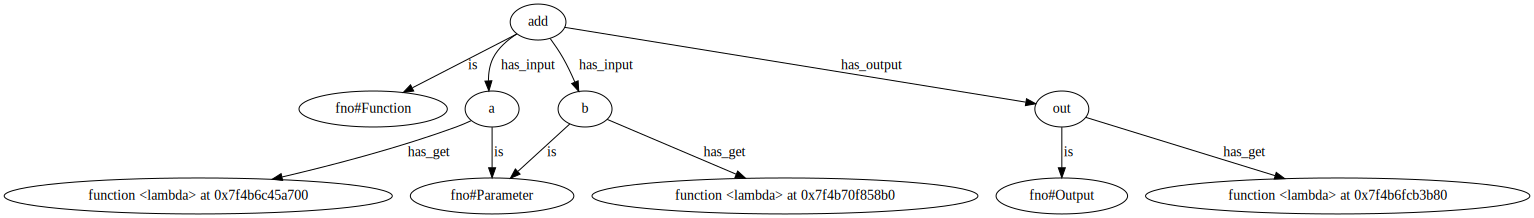

In [13]:
# Let's construct a simple graph

g = Graph()
g.clear()

# Register the above function
decl = register_function(g, add)

# res is a function that will execute the registered function
res = lambda : execute_function(decl)
    
# Build graph (will be prepared before-hand)

g.append(('out', 'is', 'fno#Output'))
g.append(('out', 'has_get', res))
g.append(('a', 'has_get', first))
g.append(('add', 'has_output', 'out'))

# Define getter functions for the concepts 'a' and 'b'
set_getter(g, decl, 'a', first)
set_getter(g, decl, 'b', last)

# Show graph
g.plot()


In [4]:
a = execute_function(decl)
print (a)

adding the numbers!
7


In [5]:
# Can also execute the function directly in a graph query
for _,_, o in g.match('out', 'has_get'):
    print (o())


7


In [15]:
# Example from VIPCOAT - inhibitor efficiency
from __future__ import annotations
from typing import List
from itertools import product
from s7.models import create_config
from s7.xlsparser import XLSParser
from s7.classgen import class_factory
import numpy as np

# Import Configuration
xls_config = create_config('/home/jovyan/work/semantic_interop_story/inhibitor_conf.yml')                                         

# Generate Specific Parser from config
parser = XLSParser(xls_config)

# Generate entity (not a S7-model yet...)
# Note that the instance of the XLSData will encaptulate the datasource, the datamodel and the generic parser
XLSData = class_factory("XLSData", parser.get())

x = XLSData()  # x is now representing a specific state of a specific individual

help(x)

Help on XLSData in module s7.classgen object:

class XLSData(BaseExt)
 |  Method resolution order:
 |      XLSData
 |      BaseExt
 |      builtins.object
 |  
 |  Methods defined here:
 |  
 |  __init__ lambda self
 |  
 |  set_property lambda self, key, value
 |  
 |  ----------------------------------------------------------------------
 |  Data descriptors defined here:
 |  
 |  casNumber
 |  
 |  impedance_kohm_24h
 |  
 |  impedance_log_24h
 |  
 |  impedance_ohm_24h
 |  
 |  inhibitorEfficiency
 |  
 |  runID
 |  
 |  sampleType
 |  
 |  ----------------------------------------------------------------------
 |  Data descriptors inherited from BaseExt:
 |  
 |  __dict__
 |      dictionary for instance variables (if defined)
 |  
 |  __weakref__
 |      list of weak references to the object (if defined)



[79.06986093749876, 78.4192737890614, 10.266326591796767, 13.668488994140477, 19.85567960937469]
{'fn': 'inhibitor_eff', 'args': {'impedance': <function <lambda> at 0x7f4b25b97ee0>}}


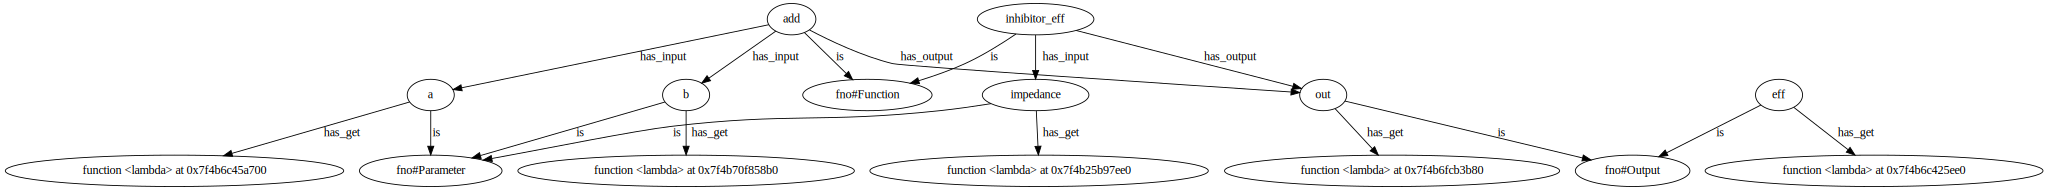

In [16]:
# Define the Ontological-Concept-Function for computing inhibitor efficiency from impendance
# using cache in case the function is called multiple times with same parameters
@functools.cache
def inhibitor_eff(impedance):
    return list(map(lambda imp : (1-13.562/imp)*100, map(float,impedance)))



# register the function
inhibitor_eff_decl = register_function(g, inhibitor_eff)
inhibitor_eff_res = lambda : execute_function(decl)

g.append(('eff', 'is', 'fno#Output'))
g.append(('eff', 'has_get', inhibitor_eff_res))

imps = list(map(float, x.impedance_kohm_24h))
set_getter(g, inhibitor_eff_decl, 'impedance', lambda : x.impedance_kohm_24h)  # mapping to datasource getter)
print (list(map(float, x.impedance_kohm_24h)))
print (inhibitor_eff_decl)

g.append(('inhibitor_eff', 'has_output', 'out'))
g.plot()

#res = execute_function(inhibitor_eff_decl)
#print ("res=",res)